Comic Vine API analysis - Noah Matos

##### First
Some modules and loading in an API key which can be created at the [Comic Vine API page](https://comicvine.gamespot.com/api/). 

In [1]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
import numpy as np

In [2]:
cv_key = pd.read_csv('comicvine key.txt')
cv_key.keys()

Index(['API-key'], dtype='object')

In [3]:
key = cv_key['API-key'].iloc[0]

##### Second

I am just going to create a few variables to hold the api base URL and structure the parameter that holds your API key.

In [4]:
api_url = 'https://comicvine.gamespot.com/api/'
key_url = 'api_key='+str(key)

In [5]:
failed_request = characters_response = requests.get(api_url + 'characters/?' + key_url + '&format=json')
failed_request.status_code

403

In [6]:
with open('comicvine_out.html', 'w') as t:
    t.write(failed_request.text)

##### Explaining the solution:
From the output html file, scroll down to the bottom and you will find the following text that explains the reason for the 403 status code:

>... Or you're running a bot that does not provide a unique user agent.
> 		<p>Please provide a UNIQUE user agent that describes you. Do not use a default user agent like "PHP", "Java", "Ruby", "wget", "curl" etc.<p>
> 		You MUST provide a UNIQUE user agent. ...and for God's sake don't impersonate another bot like Google Bot that will for sure 
> 		get you permanently banned.

This just means that header information is required for the API to return data. In this case, the header does not require the API key, but instead just needs what is called a User Agent.

This User Agent can take many forms. What I include below is a default User Agent which is not entirely what this API wants, but it works well enough for this demonstration.

To find your unique user agent, open any browser and go to this [helpful header utility](https://www.whatismybrowser.com/detect/what-is-my-user-agent/).
The top box starting with something like: `Mozilla/5.0 (Windows...` is what you could use for the `User-Agent` headers parameter instead of the default used in the example below.

In [7]:
#characters_response = requests.get(api_url + 'characters/?' + key_url + '&format=json', headers = {'User-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/18.0.1 Safari/605.1.15'})

In [8]:
#characters_response.status_code

In [9]:
#cha_dict = json.loads(characters_response.text)
#cha_dict.keys()

In [10]:
#len(cha_dict['results'])

In [11]:
#cha_dict['results'][0]

In [12]:
#cha_df = pd.DataFrame(cha_dict['results'])
#cha_df.head()

In [13]:
#spawn_response.status_code

In [14]:
#spawn = json.loads(spawn_response.text)

In [15]:
#spawn.keys()

this was all my first attempt at getting the API to work and the help that was given to me by Prof. Silva

                                                 PAGE BREAK LOL

In [16]:
char_list = ['4005-24863', '4005-3381', '4005-40550', '4005-51840', '4005-42443', '4005-5210', '4005-48901', '4005-17996', '4005-5209','4005-5195','4005-5182','4005-47906', '4005-6538', '4005-64035', '4005-17859']
responses = []
for i in char_list:
    resp = requests.get(api_url+'character/'+str(i)+'?'+key_url + '&format=json', headers = {'User-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/18.0.1 Safari/605.1.15'} )
    chj = json.loads(resp.text)
    responses.append(chj['results'])

In [17]:
print(api_url + 'character/' + str(i) + '?' + key_url)

https://comicvine.gamespot.com/api/character/4005-17859?api_key=61e513aa5ef93ccd3df87a74b91f41a6fce71448


In [18]:
ic_df = pd.DataFrame(responses)
#ic_df

I have put the Image Comic characters that I would like to focus on in their own dataframe. I did this by getting the ID's of each character manually and putting them in a list. The function that is above automatically gets the 'results' from each character's call and puts them into a dataframe.

In [19]:
ic_df['publisher'].iloc[1]

{'api_detail_url': 'https://comicvine.gamespot.com/api/publisher/4010-513/',
 'id': 513,
 'name': 'Image'}

Next, I need to make it so that that 513 code (which = image comics) reads as 'Image Comics' in the dataframe. I used chatgpt to help out below with anything that has the lambda functionaility inputted as well as this function (map_publisher_id) below. I used it because I needed to know how to isolate just the 'id' of 'publisher' and 'name' from 'powers'

In [20]:
#ic_df['powers'].iloc[0]

In [21]:
ic_df['power_names'] = ic_df['powers'].apply(lambda x: [power['name'] for power in x] if isinstance(x, list) else None)

In [22]:
ic_df['publisher_id'] = ic_df['publisher'].apply(lambda x: x.get('id') if x else None)

adds pubilsher_id and power_names to the dataframe

In [23]:
ic_df_tidy  = ic_df.drop(columns = ['story_arc_credits', 'team_enemies', 'team_friends', 'volume_credits', 'teams', 'character_enemies', 'character_friends', 'birth', 'image', 'creators', 'issue_credits', 'movies', 'issues_died_in', 'origin', 'description', 'first_appeared_in_issue', 'powers', 'aliases', 'api_detail_url'])
#ic_df_tidy.sort_values(by='name')

dropped irrelevant columns

In [24]:
image_df = ic_df_tidy[['name','real_name','power_names', 'count_of_issue_appearances','gender','id','deck','date_added','date_last_updated','site_detail_url','publisher', 'publisher_id']]

put them in the order that I wanted them

In [25]:
image_df['publisher_id'] = image_df['publisher'].apply(lambda x: x.get('id') if x else None)

In [26]:
def map_publisher_id(x):
    if x.get('id') == 513:
        return 'Image Comics'
    elif x.get('id') == 521:
        return 'Image Comics'
    else:
        return None  # Default to None if no match

image_df['publisher_type'] = image_df['publisher'].apply(lambda x: map_publisher_id(x) if x else None)

This creates a new column called publisher_type and translates the publisher ID into a string that reads, "Image Comics" (ChatGPT assisted)

In [27]:
image_df.sort_values(by='count_of_issue_appearances', ascending = False)

,name,real_name,power_names,count_of_issue_appearances,gender,id,deck,date_added,date_last_updated,site_detail_url,publisher,publisher_id,publisher_type
1,Spawn (Simmons),Al Simmons,"[Flight, Super Strength, Super Speed, Agility,...",1491,1,3381,"A highly trained assassin, murdered by his emp...",2008-06-06 11:27:42,2024-08-17 07:14:45,https://comicvine.gamespot.com/spawn-simmons/4...,{'api_detail_url': 'https://comicvine.gamespot...,513,Image Comics
8,Savage Dragon,Kurr,"[Super Strength, Super Speed, Agility, Stamina...",579,1,5209,Savage Dragon is a green-skinned superhero/ali...,2008-06-06 11:27:36,2023-03-06 06:44:37,https://comicvine.gamespot.com/savage-dragon/4...,{'api_detail_url': 'https://comicvine.gamespot...,513,Image Comics
4,Rick Grimes,Richard Grimes,"[Intellect, Weapon Master, Unarmed Combat, Mar...",501,1,42443,Rick Grimes was formerly a police officer in t...,2008-06-06 11:27:28,2023-06-23 07:17:18,https://comicvine.gamespot.com/rick-grimes/400...,{'api_detail_url': 'https://comicvine.gamespot...,513,Image Comics
5,Invincible,Markus Sebastian Grayson,"[Flight, Super Strength, Super Speed, Agility,...",444,1,5210,"Girls, acne, homework and supervillains. When ...",2008-06-06 11:27:37,2024-03-02 06:00:28,https://comicvine.gamespot.com/invincible/4005...,{'api_detail_url': 'https://comicvine.gamespot...,513,Image Comics
7,SuperPatriot,John Quincy Armstrong,"[Super Strength, Agility, Stamina, Invulnerabi...",259,1,17996,"An American soldier of World War II, who was c...",2008-06-06 11:27:32,2021-04-10 23:57:15,https://comicvine.gamespot.com/superpatriot/40...,{'api_detail_url': 'https://comicvine.gamespot...,513,Image Comics
9,Shadowhawk,Eddie Collins,"[Super Strength, Super Speed, Agility, Intelle...",197,1,5195,Various men and women throughout the ages have...,2008-06-06 11:27:34,2024-02-22 09:46:13,https://comicvine.gamespot.com/shadowhawk/4005...,{'api_detail_url': 'https://comicvine.gamespot...,513,Image Comics
11,Cassie Hack,Cassandra Hack,"[Agility, Stamina, Weapon Master, Unarmed Comb...",191,2,47906,Cassie Hack is the lone survivor of an attack ...,2008-06-06 11:27:20,2024-05-18 13:47:52,https://comicvine.gamespot.com/cassie-hack/400...,{'api_detail_url': 'https://comicvine.gamespot...,513,Image Comics
10,Shaft,Jeff Allan Terrell,"[Weapon Master, Unarmed Combat, Gadgets, Sword...",186,1,5182,Former FBI Agent Jeff Terrell is recruited to ...,2008-06-06 11:27:33,2021-10-01 22:58:02,https://comicvine.gamespot.com/shaft/4005-5182/,{'api_detail_url': 'https://comicvine.gamespot...,513,Image Comics
12,Supreme,Ethan Thomas Crane,"[Flight, Super Strength, Super Speed, Agility,...",161,1,6538,The equivalent of Superman in Rob Liefeld's co...,2008-06-06 11:27:36,2024-03-07 20:28:36,https://comicvine.gamespot.com/supreme/4005-6538/,{'api_detail_url': 'https://comicvine.gamespot...,513,Image Comics
2,Omni-Man,Nolan,"[Flight, Super Strength, Super Speed, Agility,...",156,1,40550,Father of the famous teen superhero Invincible...,2008-06-06 11:27:34,2023-06-24 21:30:39,https://comicvine.gamespot.com/omni-man/4005-4...,{'api_detail_url': 'https://comicvine.gamespot...,513,Image Comics


this dataframe is now tidy as I have gotten rid of unnecessary columns as well as simplifying a few that were too complicated.


i would like to make a note that these characters were not as a popular as i thought and appeared in many less issues. Originally I was going to see how many issues each character was getting over the years and if they were gaining popularity. From the keys in this dataframe I am not really able to work with the data from over the years. My next idea is to pit these image comic characters against marvel characters and see if there is a correlation between the different powers and count of issues appeared.


                                                    PAGE BREAK                  

In [28]:
m_char_list = ['4005-1443', '4005-1440', '4005-1442', '4005-1459', '4005-1455', '4005-2268', '4005-2267', '4005-2151', '4005-1456','4005-24694','4005-1462','4005-1468', '4005-7606', '4005-1477']
m_responses = []
for i in m_char_list:
    m_resp = requests.get(api_url+'character/'+str(i)+'?'+key_url + '&format=json', headers = {'User-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/18.0.1 Safari/605.1.15'} )
    m_chj = json.loads(m_resp.text)
    m_responses.append(m_chj['results'])

In [29]:
marvel_df = pd.DataFrame(m_responses)
#marvel_df.sort_values(by='count_of_issue_appearances', ascending = False)

this is the same process I went through earlier with Image Comic characters, but with Marvel Comic characters

In [30]:
marvel_df['publisher'].iloc[1]

{'api_detail_url': 'https://comicvine.gamespot.com/api/publisher/4010-31/',
 'id': 31,
 'name': 'Marvel'}

Below, I translated the publisher ID into actual words, as well as doing the same for 'powers' (ChatGPT assisted)

In [31]:
marvel_df['power_names'] = marvel_df['powers'].apply(lambda x: [power['name'] for power in x] if isinstance(x, list) else None)

In [32]:
marvel_df['publisher_id'] = ic_df['publisher'].apply(lambda x: x.get('id') if x else None)

In [33]:
tidy_marvel_df = marvel_df[['name','real_name','power_names', 'count_of_issue_appearances','gender','id','deck','date_added','date_last_updated','site_detail_url', 'publisher', 'publisher_id']]
tidy_marvel_df.sort_values(by='count_of_issue_appearances', ascending = False)

,name,real_name,power_names,count_of_issue_appearances,gender,id,deck,date_added,date_last_updated,site_detail_url,publisher,publisher_id
0,Spider-Man,Peter Benjamin Parker,"[Super Strength, Super Speed, Agility, Stamina...",17500,1,1443,Peter Parker was bitten by a radioactive spide...,2008-06-06 11:27:11,2024-11-27 04:41:42,https://comicvine.gamespot.com/spider-man/4005...,{'api_detail_url': 'https://comicvine.gamespot...,521
1,Wolverine,James Howlett,"[Super Strength, Agility, Stamina, Invulnerabi...",16396,1,1440,A long-lived mutant with the rage of a beast a...,2008-06-06 11:25:14,2024-10-07 03:58:34,https://comicvine.gamespot.com/wolverine/4005-...,{'api_detail_url': 'https://comicvine.gamespot...,513
2,Captain America,Steven Grant Rogers,"[Super Strength, Agility, Stamina, Intellect, ...",11902,1,1442,"During World War II, Steve Rogers volunteered ...",2008-06-06 11:27:42,2024-12-04 03:43:49,https://comicvine.gamespot.com/captain-america...,{'api_detail_url': 'https://comicvine.gamespot...,513
3,Cyclops,Scott Summers,"[Agility, Stamina, Intellect, Blast Power, Una...",11385,1,1459,"The first X-Man, Scott Summers possesses the m...",2008-06-06 11:27:42,2024-09-26 07:46:13,https://comicvine.gamespot.com/cyclops/4005-1459/,{'api_detail_url': 'https://comicvine.gamespot...,513
4,Iron Man,Anthony Edward Stark,"[Flight, Super Strength, Super Speed, Stamina,...",11359,1,1455,"Tony Stark was the arrogant son of wealthy, we...",2008-06-06 11:27:42,2024-11-27 14:05:03,https://comicvine.gamespot.com/iron-man/4005-1...,{'api_detail_url': 'https://comicvine.gamespot...,513
10,Beast,Henry Philip McCoy,"[Super Strength, Super Speed, Agility, Stamina...",9781,1,1462,"A founding member of the X-Men, Dr. Hank McCoy...",2008-06-06 11:27:42,2024-12-04 14:59:48,https://comicvine.gamespot.com/beast/4005-1462/,{'api_detail_url': 'https://comicvine.gamespot...,513
5,Thor,Thor Odinson,"[Flight, Super Strength, Super Speed, Agility,...",8734,1,2268,Thor Odinson is the All-father of Asgard /God ...,2008-06-06 11:27:42,2024-12-02 16:57:12,https://comicvine.gamespot.com/thor/4005-2268/,{'api_detail_url': 'https://comicvine.gamespot...,513
6,Hulk,Robert Bruce Banner,"[Super Strength, Super Speed, Agility, Stamina...",7886,1,2267,After being bombarded with a massive dose of g...,2008-06-06 11:27:42,2024-11-27 11:09:27,https://comicvine.gamespot.com/hulk/4005-2267/,{'api_detail_url': 'https://comicvine.gamespot...,513
7,Mr. Fantastic,Reed Richards,"[Agility, Stamina, Invulnerability, Intellect,...",6963,1,2151,"Reed Richards, also known as Mr. Fantastic, is...",2008-06-06 11:27:42,2024-10-04 12:17:34,https://comicvine.gamespot.com/mr-fantastic/40...,{'api_detail_url': 'https://comicvine.gamespot...,513
8,Doctor Strange,Stephen Vincent Strange,"[Flight, Agility, Stamina, Telepathy, Telekine...",5012,1,1456,Dr. Stephen Strange was once a gifted but egot...,2008-06-06 11:27:42,2024-11-23 10:04:27,https://comicvine.gamespot.com/doctor-strange/...,{'api_detail_url': 'https://comicvine.gamespot...,513


In [34]:
tidy_marvel_df['publisher_id'] = tidy_marvel_df['publisher'].apply(lambda x: x.get('id') if x else None)

/var/folders/82/9t585cz90wd9lg9jkmx49fjm0000gn/T/ipykernel_6848/3890227136.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidy_marvel_df['publisher_id'] = tidy_marvel_df['publisher'].apply(lambda x: x.get('id') if x else None)


In [35]:
def map_publisher_id(x):
    if x.get('id') == 31:
        return 'Marvel Comics'
    else:
        return None  # Default to None if no match

tidy_marvel_df['publisher_type'] = tidy_marvel_df['publisher'].apply(lambda x: map_publisher_id(x) if x else None)

/var/folders/82/9t585cz90wd9lg9jkmx49fjm0000gn/T/ipykernel_6848/1409967365.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidy_marvel_df['publisher_type'] = tidy_marvel_df['publisher'].apply(lambda x: map_publisher_id(x) if x else None)


These cells, while reporting a documentation error, do work. This creates a new column called publisher_type and translates the publisher ID into a string that reads, "Marvel Comics" (ChatGPT assisted)

In [36]:
tidy_marvel_df

,name,real_name,power_names,count_of_issue_appearances,gender,id,deck,date_added,date_last_updated,site_detail_url,publisher,publisher_id,publisher_type
0,Spider-Man,Peter Benjamin Parker,"[Super Strength, Super Speed, Agility, Stamina...",17500,1,1443,Peter Parker was bitten by a radioactive spide...,2008-06-06 11:27:11,2024-11-27 04:41:42,https://comicvine.gamespot.com/spider-man/4005...,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
1,Wolverine,James Howlett,"[Super Strength, Agility, Stamina, Invulnerabi...",16396,1,1440,A long-lived mutant with the rage of a beast a...,2008-06-06 11:25:14,2024-10-07 03:58:34,https://comicvine.gamespot.com/wolverine/4005-...,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
2,Captain America,Steven Grant Rogers,"[Super Strength, Agility, Stamina, Intellect, ...",11902,1,1442,"During World War II, Steve Rogers volunteered ...",2008-06-06 11:27:42,2024-12-04 03:43:49,https://comicvine.gamespot.com/captain-america...,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
3,Cyclops,Scott Summers,"[Agility, Stamina, Intellect, Blast Power, Una...",11385,1,1459,"The first X-Man, Scott Summers possesses the m...",2008-06-06 11:27:42,2024-09-26 07:46:13,https://comicvine.gamespot.com/cyclops/4005-1459/,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
4,Iron Man,Anthony Edward Stark,"[Flight, Super Strength, Super Speed, Stamina,...",11359,1,1455,"Tony Stark was the arrogant son of wealthy, we...",2008-06-06 11:27:42,2024-11-27 14:05:03,https://comicvine.gamespot.com/iron-man/4005-1...,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
5,Thor,Thor Odinson,"[Flight, Super Strength, Super Speed, Agility,...",8734,1,2268,Thor Odinson is the All-father of Asgard /God ...,2008-06-06 11:27:42,2024-12-02 16:57:12,https://comicvine.gamespot.com/thor/4005-2268/,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
6,Hulk,Robert Bruce Banner,"[Super Strength, Super Speed, Agility, Stamina...",7886,1,2267,After being bombarded with a massive dose of g...,2008-06-06 11:27:42,2024-11-27 11:09:27,https://comicvine.gamespot.com/hulk/4005-2267/,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
7,Mr. Fantastic,Reed Richards,"[Agility, Stamina, Invulnerability, Intellect,...",6963,1,2151,"Reed Richards, also known as Mr. Fantastic, is...",2008-06-06 11:27:42,2024-10-04 12:17:34,https://comicvine.gamespot.com/mr-fantastic/40...,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
8,Doctor Strange,Stephen Vincent Strange,"[Flight, Agility, Stamina, Telepathy, Telekine...",5012,1,1456,Dr. Stephen Strange was once a gifted but egot...,2008-06-06 11:27:42,2024-11-23 10:04:27,https://comicvine.gamespot.com/doctor-strange/...,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
9,Daredevil,Matthew Michael Murdock,"[Agility, Stamina, Intellect, Radar Sense, Wea...",4835,1,24694,"As a child, Matt Murdock was blinded by radioa...",2008-06-06 11:27:42,2024-11-20 17:20:09,https://comicvine.gamespot.com/daredevil/4005-...,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics


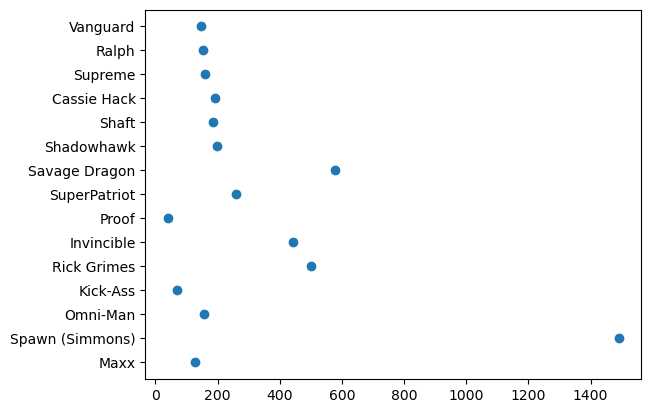

In [37]:
fig3, ax3 = plt.subplots()
ax3.scatter(image_df['count_of_issue_appearances'], image_df['name'])
plt.show()

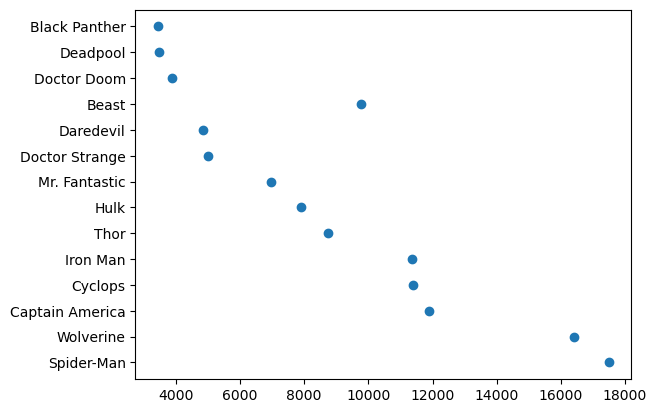

In [38]:
fig4, ax4 = plt.subplots()
ax4.scatter(marvel_df['count_of_issue_appearances'], marvel_df['name'])
plt.show()

I drew these two figures to see if there was a correlation between each superhero and count of issues appeared. This is a useless graph because obviously more popular superheroes are going to get more issues. This was more an excercise to see if the data acquired so far was applicable.

In [39]:
tidy_marvel_df['power_names'].iloc[0]

['Super Strength',
 'Super Speed',
 'Agility',
 'Stamina',
 'Intellect',
 'Healing',
 'Feral',
 'Gadgets',
 'Siphon Abilities',
 'Wall Clinger',
 'Danger Sense',
 'Berserker Strength',
 'Webslinger']

In [40]:
marvel_powers = pd.DataFrame(tidy_marvel_df['power_names'])
image_powers = pd.DataFrame(image_df['power_names'])

This turns the power names from each dataframe into their own dataframes for Marvel and Image Comics respectively

These two graphs below visualize the top 15 powers for each publisher (ChatGPT assisted)

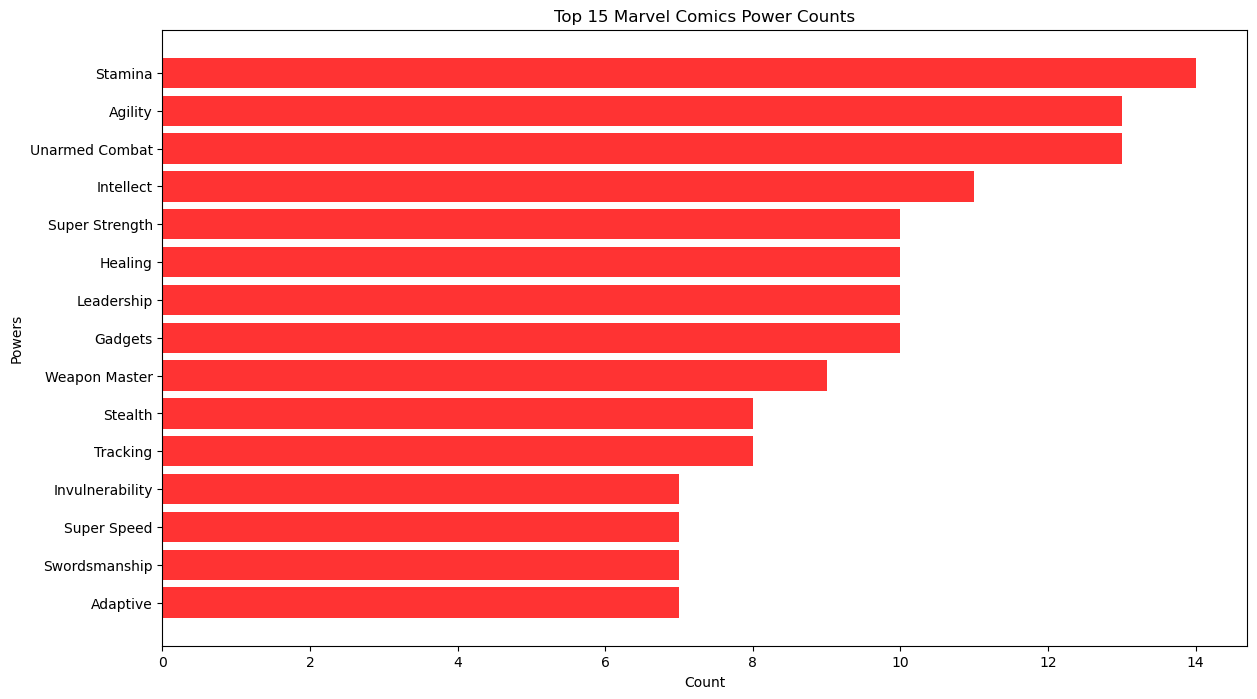

In [41]:
# Step 1: Explode the power_names column to get individual powers
marvel_powers = tidy_marvel_df.explode('power_names')[['power_names']]
marvel_powers = marvel_powers.rename(columns={'power_names': 'Power'})  # Rename for clarity

# Step 2: Count the frequency of each power
mpower_counts = marvel_powers['Power'].value_counts().reset_index()
mpower_counts.columns = ['Power', 'Count']  # Rename columns

# Step 3: Select the top 15 most common powers
mtop_powers = mpower_counts.head(15)

# Step 4: Plot the data
plt.figure(figsize=(14, 8))
plt.barh(mtop_powers['Power'], mtop_powers['Count'], color='red', alpha=0.8)
plt.title("Top 15 Marvel Comics Power Counts")
plt.xlabel("Count")
plt.ylabel("Powers")
plt.gca().invert_yaxis()  # Invert Y-axis for readability
plt.show()

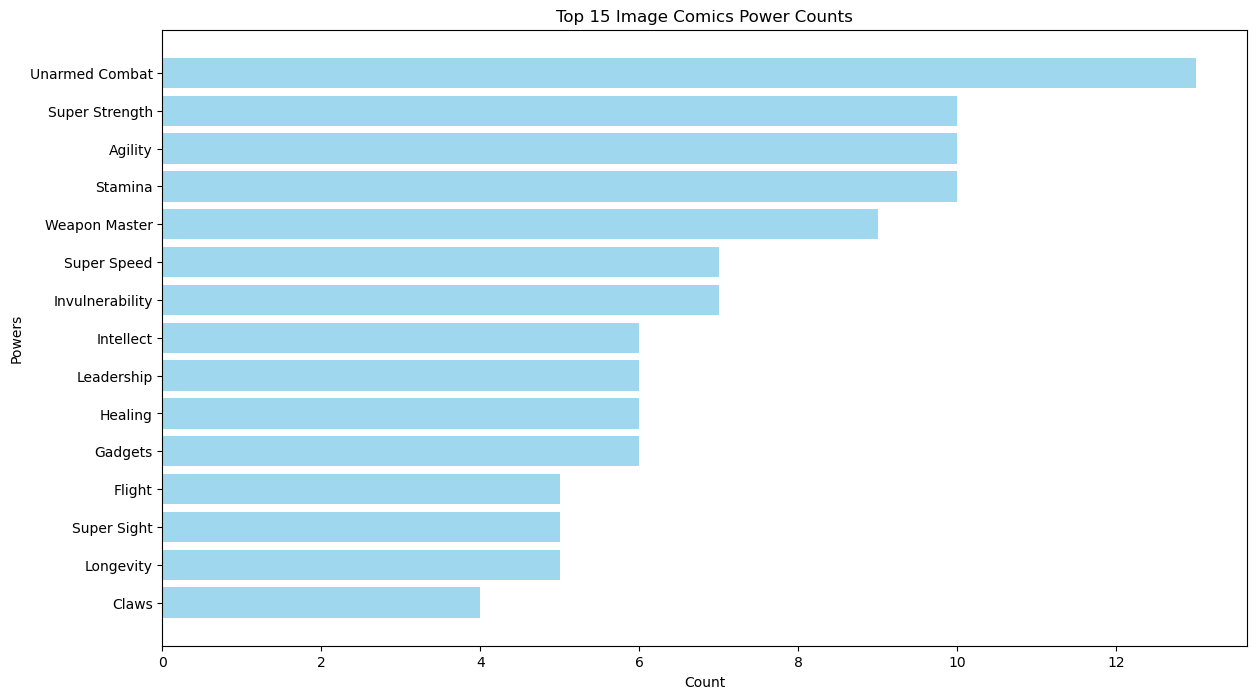

In [42]:
# Step 1: Explode the power_names column to get individual powers
image_powers = image_df.explode('power_names')[['power_names']]
image_powers = image_powers.rename(columns={'power_names': 'Power'})  # Rename for clarity

# Step 2: Count the frequency of each power
ipower_counts = image_powers['Power'].value_counts().reset_index()
ipower_counts.columns = ['Power', 'Count']  # Rename columns

# Step 3: Select the top 15 most common powers
itop_powers = ipower_counts.head(15)

# Step 4: Plot the data
plt.figure(figsize=(14, 8))
plt.barh(itop_powers['Power'], itop_powers['Count'], color='skyblue', alpha=0.8)
plt.title("Top 15 Image Comics Power Counts")
plt.xlabel("Count")
plt.ylabel("Powers")
plt.gca().invert_yaxis()  # Invert Y-axis for readability
plt.show()

In [43]:
merged_df = pd.concat([tidy_marvel_df, image_df], ignore_index=True)
#merged_df.drop(['name','real_name','power_names','gender','id','deck','date_added','date_last_updated','site_detail_url'], axis=1, inplace=True)
merged_df

,name,real_name,power_names,count_of_issue_appearances,gender,id,deck,date_added,date_last_updated,site_detail_url,publisher,publisher_id,publisher_type
0,Spider-Man,Peter Benjamin Parker,"[Super Strength, Super Speed, Agility, Stamina...",17500,1,1443,Peter Parker was bitten by a radioactive spide...,2008-06-06 11:27:11,2024-11-27 04:41:42,https://comicvine.gamespot.com/spider-man/4005...,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
1,Wolverine,James Howlett,"[Super Strength, Agility, Stamina, Invulnerabi...",16396,1,1440,A long-lived mutant with the rage of a beast a...,2008-06-06 11:25:14,2024-10-07 03:58:34,https://comicvine.gamespot.com/wolverine/4005-...,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
2,Captain America,Steven Grant Rogers,"[Super Strength, Agility, Stamina, Intellect, ...",11902,1,1442,"During World War II, Steve Rogers volunteered ...",2008-06-06 11:27:42,2024-12-04 03:43:49,https://comicvine.gamespot.com/captain-america...,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
3,Cyclops,Scott Summers,"[Agility, Stamina, Intellect, Blast Power, Una...",11385,1,1459,"The first X-Man, Scott Summers possesses the m...",2008-06-06 11:27:42,2024-09-26 07:46:13,https://comicvine.gamespot.com/cyclops/4005-1459/,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
4,Iron Man,Anthony Edward Stark,"[Flight, Super Strength, Super Speed, Stamina,...",11359,1,1455,"Tony Stark was the arrogant son of wealthy, we...",2008-06-06 11:27:42,2024-11-27 14:05:03,https://comicvine.gamespot.com/iron-man/4005-1...,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
5,Thor,Thor Odinson,"[Flight, Super Strength, Super Speed, Agility,...",8734,1,2268,Thor Odinson is the All-father of Asgard /God ...,2008-06-06 11:27:42,2024-12-02 16:57:12,https://comicvine.gamespot.com/thor/4005-2268/,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
6,Hulk,Robert Bruce Banner,"[Super Strength, Super Speed, Agility, Stamina...",7886,1,2267,After being bombarded with a massive dose of g...,2008-06-06 11:27:42,2024-11-27 11:09:27,https://comicvine.gamespot.com/hulk/4005-2267/,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
7,Mr. Fantastic,Reed Richards,"[Agility, Stamina, Invulnerability, Intellect,...",6963,1,2151,"Reed Richards, also known as Mr. Fantastic, is...",2008-06-06 11:27:42,2024-10-04 12:17:34,https://comicvine.gamespot.com/mr-fantastic/40...,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
8,Doctor Strange,Stephen Vincent Strange,"[Flight, Agility, Stamina, Telepathy, Telekine...",5012,1,1456,Dr. Stephen Strange was once a gifted but egot...,2008-06-06 11:27:42,2024-11-23 10:04:27,https://comicvine.gamespot.com/doctor-strange/...,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
9,Daredevil,Matthew Michael Murdock,"[Agility, Stamina, Intellect, Radar Sense, Wea...",4835,1,24694,"As a child, Matt Murdock was blinded by radioa...",2008-06-06 11:27:42,2024-11-20 17:20:09,https://comicvine.gamespot.com/daredevil/4005-...,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics


this combines both the Image Comics and Marvel Comics dataframes into one

In [44]:
merged_df['Power_Value'] = 1
powers = merged_df[['name', 'power_names', 'Power_Value']].explode('power_names')
powers_df_wide = powers.pivot(index = 'name', columns = 'power_names', values = 'Power_Value').fillna(0)

In [45]:
not_final = pd.merge(powers_df_wide, merged_df, how = 'inner', left_index = True, right_on = 'name')
not_final = not_final.drop(columns = ['publisher', 'publisher_id'])

In [46]:
not_final.groupby('publisher_type').sum()

,Adaptive,Agility,Animal Control,Animation,Astral Projection,Berserker Strength,Blast Power,Chameleon,Chemical Absorbtion,Claws,...,real_name,power_names,count_of_issue_appearances,gender,id,deck,date_added,date_last_updated,site_detail_url,Power_Value
publisher_type,,,,,,,,,,,,,,,,,,,,,
Image Comics,3.0,10.0,0.0,2.0,0.0,3.0,2.0,1.0,1.0,4.0,...,Cassandra HackMarkus Sebastian GraysonDavid Li...,"[Agility, Stamina, Weapon Master, Unarmed Comb...",4699,16,387108,Cassie Hack is the lone survivor of an attack ...,2008-06-06 11:27:202008-06-06 11:27:372008-06-...,2024-05-18 13:47:522024-03-02 06:00:282019-05-...,https://comicvine.gamespot.com/cassie-hack/400...,15
Marvel Comics,7.0,13.0,1.0,2.0,3.0,6.0,6.0,1.0,1.0,4.0,...,Henry Philip McCoyT'ChallaSteven Grant RogersS...,"[Super Strength, Super Speed, Agility, Stamina...",122533,14,52088,"A founding member of the X-Men, Dr. Hank McCoy...",2008-06-06 11:27:422008-06-06 11:27:422008-06-...,2024-12-04 14:59:482024-10-04 09:42:212024-12-...,https://comicvine.gamespot.com/beast/4005-1462...,14


From here, with Prof. Silva's help of course, I was able to structure the Dataframe by publisher_type and power_names. Next I assigned 1's to the power_name column if the hero in question has that power; 1's being yes and 0's being no. From there I grouped by publisher and should soon be able to make a scatter plot with count_of_issue_appearances on the y axis and powers (as their 1's and 0's) on the x axis

In [136]:
#shows what each publisher issue value is
not_final_exploded = not_final.explode('publisher_type')

#sort by most issues first
publisher_counts = publisher_counts.sort_values('count_of_issue_appearances', ascending=False)

publisher_counts

,publisher_type,count_of_issue_appearances
1,Marvel Comics,122533
0,Image Comics,4699


In [181]:
power_columns = [col for col in not_final.columns if col not in ['publisher_type', 'real_name', 'power_names', 'count_of_issue_appearances', 'deck', 'date_added', 'date_last_updated','site_detail_url','name','gender','id', 'Power_Value']]

power_sums = pd.DataFrame(not_final[power_columns].sum())
power_sums.index

Index(['Adaptive', 'Agility', 'Animal Control', 'Animation',
       'Astral Projection', 'Berserker Strength', 'Blast Power', 'Chameleon',
       'Chemical Absorbtion', 'Claws',
       ...
       'Vampirism', 'Vibration Wave', 'Voice-induced Manipulation',
       'Wall Clinger', 'Water Control', 'Weapon Master', 'Weather Control',
       'Webslinger', 'Willpower-Based Constructs', 'Wind Bursts'],
      dtype='object', length=110)

In [185]:
power_sums

,0
Adaptive,10.0
Agility,23.0
Animal Control,1.0
Animation,4.0
Astral Projection,3.0
...,...
Weapon Master,18.0
Weather Control,1.0
Webslinger,1.0
Willpower-Based Constructs,3.0


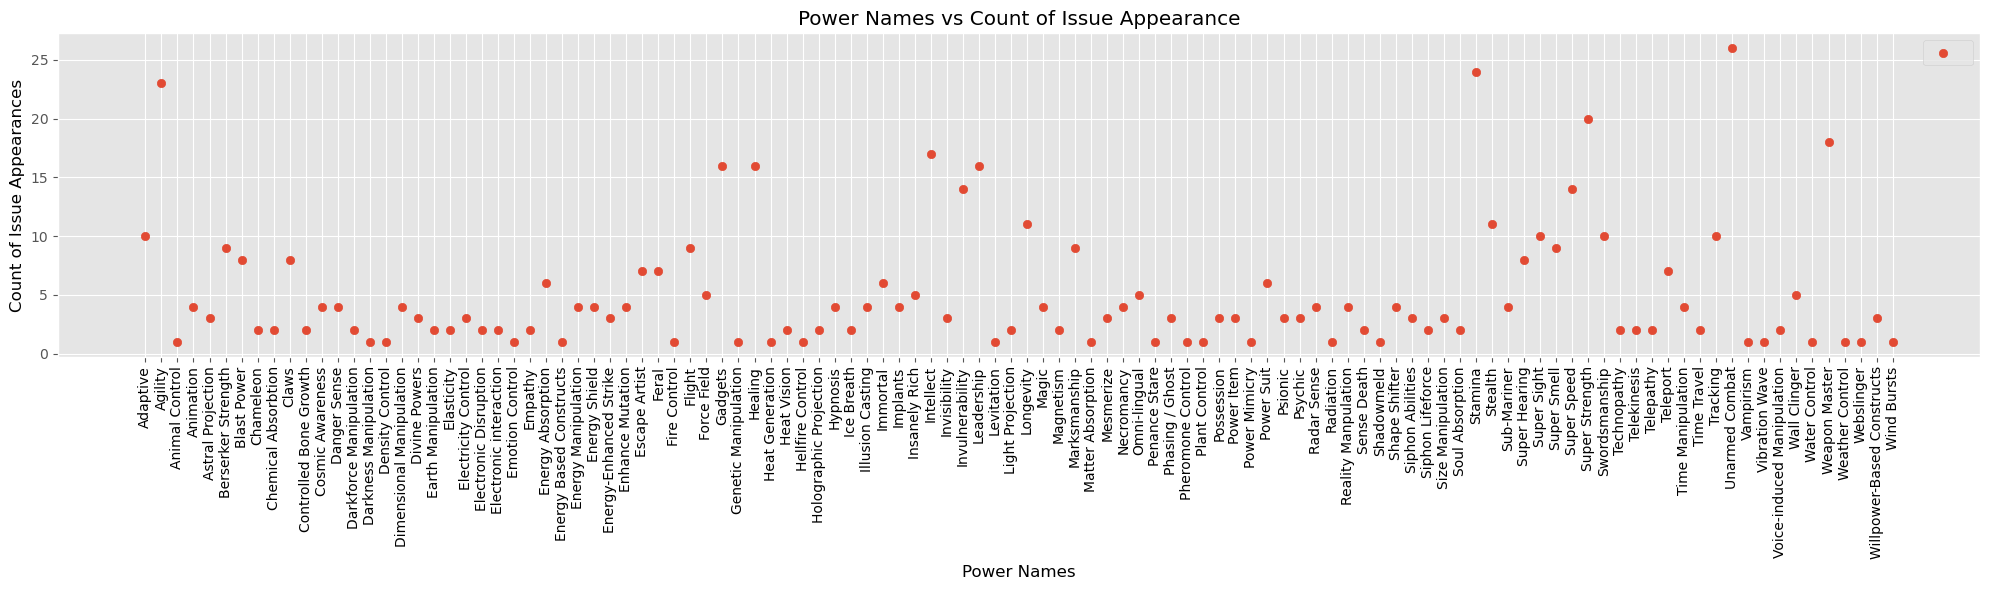

In [186]:
fig5, ax5 = plt.subplots(figsize = (20,6))
ax5.scatter(power_sums.index, power_sums[0])
ax5.set_title('Power Names vs Count of Issue Appearance')
ax5.set_xlabel('Power Names', color = 'black')
ax5.set_ylabel('Count of Issue Appearances', color = 'black')
ax5.legend([''])
plt.style.use('ggplot')
plt.xticks(rotation=90, color='black')
plt.tight_layout()
plt.show()